In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

# Store Item Demand data

In [2]:
sales = acquire.sales_data()
items = acquire.items_data()
stores = acquire.stores_data()
df = acquire.combine_heb_data(sales, items, stores)
df = prepare.prep_heb_data(df)

Reading from local CSV...
Reading from local CSV...
Reading from local CSV...


In [3]:
df.head(2)

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,items_sold,sale_id,store_id,store_address,store_city,store_state,store_zipcode,month,weekday,dollars_sold
sale_date,,,,,,,,,,,,,,,,
2013-01-01,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,01-Jan,2-Tue,10.92
2013-01-01,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,01-Jan,2-Tue,218.40


In [4]:
# pull out only target columns and get the total for each day
df = df.groupby(df.index)[['dollars_sold', 'items_sold']].sum()
df.head()

,dollars_sold,items_sold
sale_date,,
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


#### Train Validate Test Split

In [5]:
def train_validate_test_split(df, train_size=.5, validate_size=.3):

    train_end = int(len(df) * train_size)
    validate_end = train_end + int(len(df) * validate_size)

    train = df[:train_end]
    validate = df[train_end:validate_end]
    test = df[validate_end:]
    
    return train, validate, test

In [6]:
train, validate, test = prepare.train_validate_test_split(df)

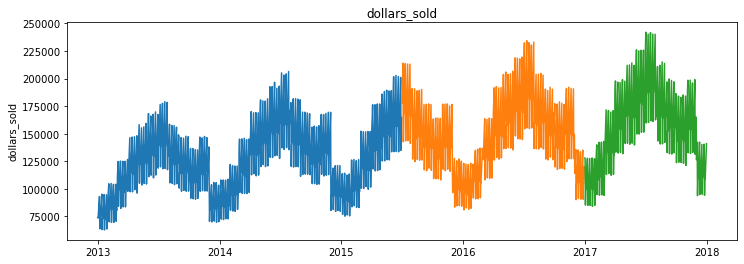

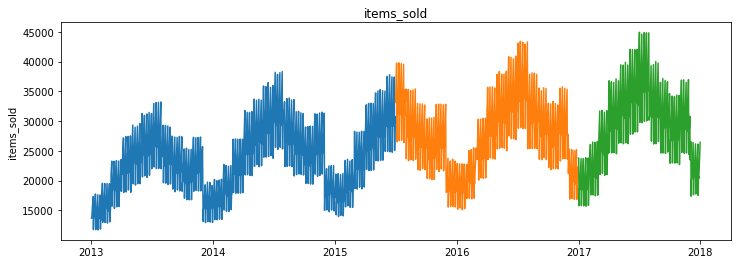

In [7]:
# visualize splits
for col in train.columns:
    plt.figure(figsize=(12,4))
    for sample in [train, validate, test]:
        plt.plot(sample[col])
    plt.title(col)
    plt.ylabel(col)
    plt.show()


#### univariate distributions

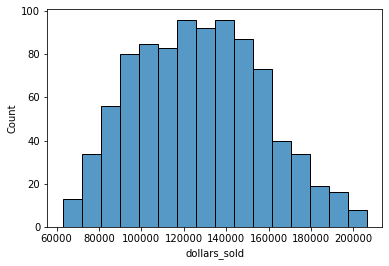

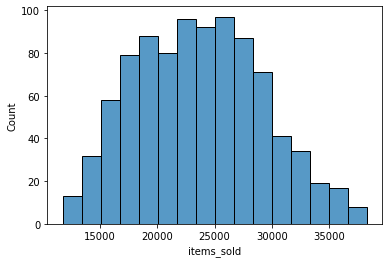

In [8]:
for col in train.columns:
    sns.histplot(train[col])
    plt.show()

#### averages by month

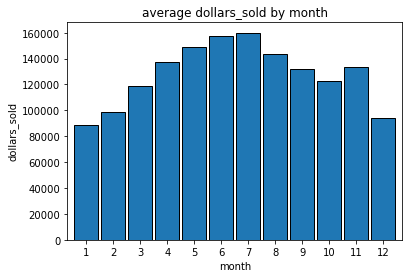

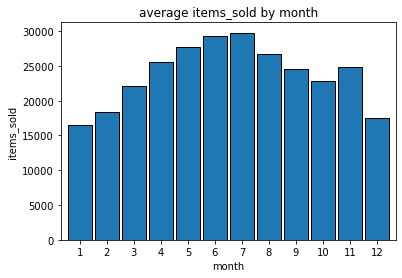

In [9]:
for col in train.columns:
    train[col].groupby(train.index.month).mean().plot.bar(rot=0, width=.9, ec='black')
    plt.xlabel('month')
    plt.ylabel(col)
    plt.title(f'average {col} by month')
    plt.show()

#### averages by weekday

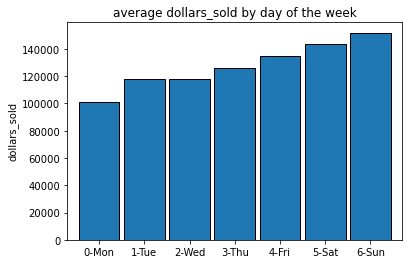

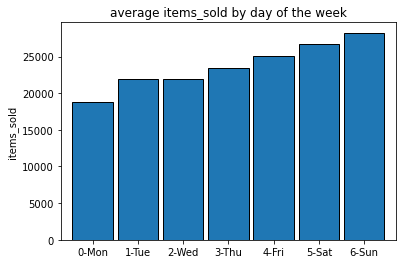

In [10]:
train['weekday'] = train.index.weekday.astype(str) + '-' + train.index.strftime('%a')
for col in ['dollars_sold', 'items_sold']:
    train.groupby('weekday')[col].mean().plot.bar(rot=0, width=.9, ec='black')
    plt.xlabel(None)
    plt.ylabel(col)
    plt.title(f'average {col} by day of the week')
    plt.show()
train = train.drop(columns='weekday')

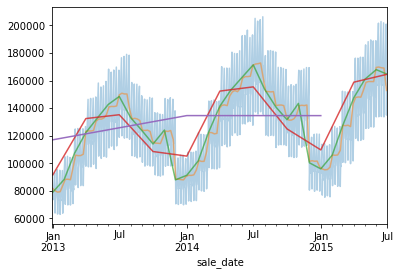

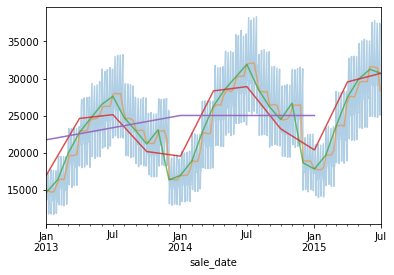

In [11]:
periods = ['D', 'W', 'M','Q', 'Y']

for col in train.columns:
    alpha = .2
    for per in periods:
        alpha += .15
        train[col].resample(per).mean().plot(alpha=alpha) 
    plt.show()

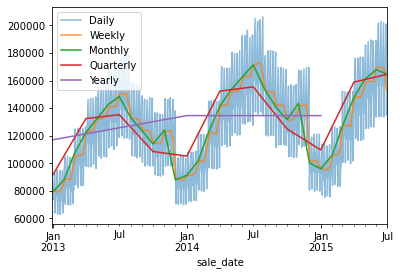

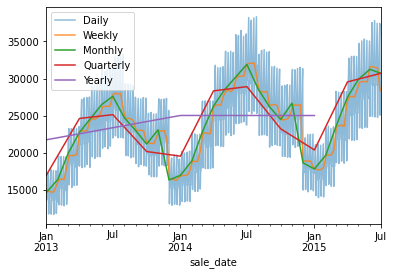

In [12]:
for col in train.columns:
    train[col].resample('D').mean().plot(alpha=.5, label='Daily')
    train[col].resample('W').mean().plot(alpha=.8, label='Weekly')
    train[col].resample('M').mean().plot(label='Monthly')
    train[col].resample('Q').mean().plot(label='Quarterly')
    train[col].resample('Y').mean().plot(label='Yearly')
    plt.legend()
    plt.show()

####  Change between periods

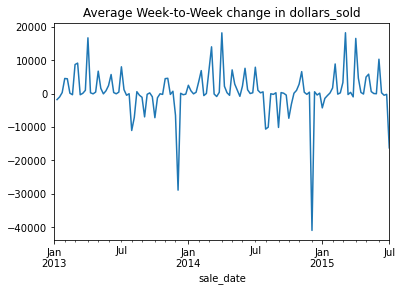

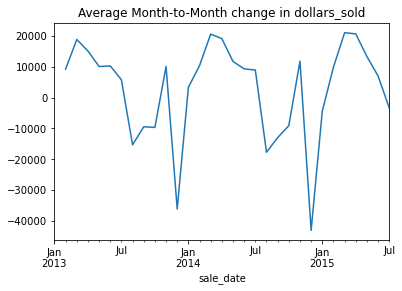

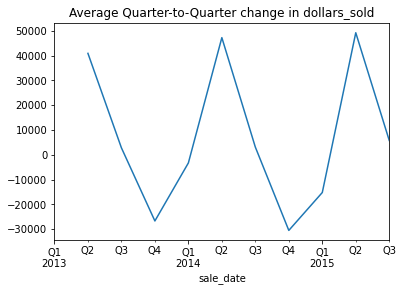

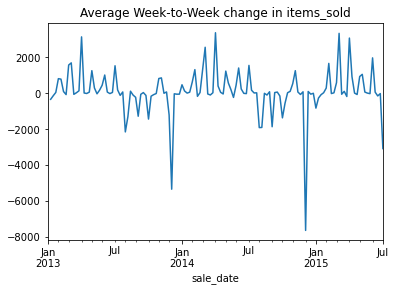

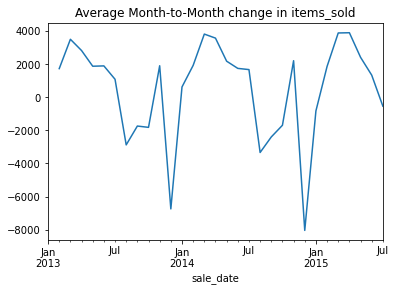

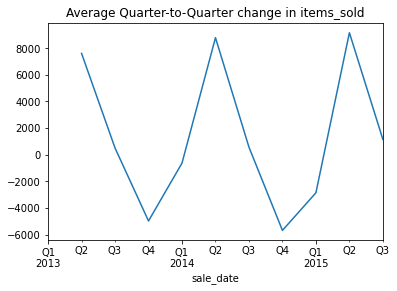

In [13]:
per = ['W', 'M', 'Q'] # list of periods by which to resample
per_name = ['Week', 'Month', 'Quarter'] # readable names of those periods
for col in train.columns:
    for i in range(len(per)):
        train[col].resample(per[i]).mean().diff().plot(title=f'Average {per_name[i]}-to-{per_name[i]} change in {col}')
        plt.show()

#### Seasonal Plot

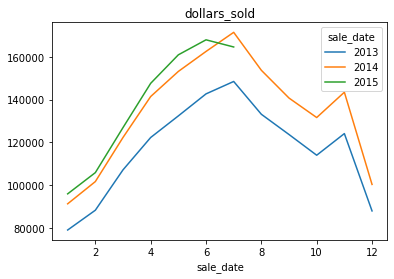

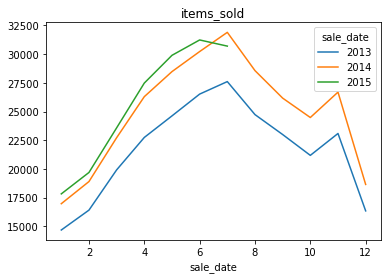

In [14]:
for col in train.columns:
    train[col].groupby([train[col].index.year, train[col].index.month]).mean().unstack(0).plot()
    plt.title(col)
    plt.show()

#### Seasonal Subseries Plot

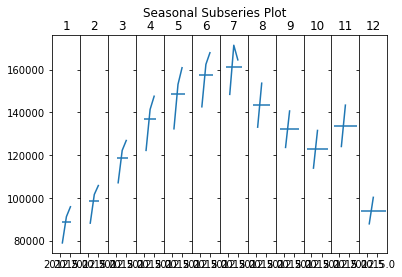

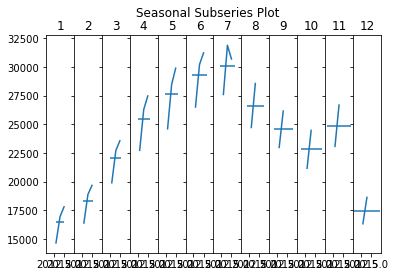

In [15]:
for col in train.columns:
    table = train[col].groupby([train[col].index.year, train[col].index.month]).mean().unstack()
    fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
    for ax, (month, subset) in zip(axs, table.iteritems()):
        subset.plot(ax=ax, title=month)
        ax.hlines(subset.mean(), *ax.get_xlim())
        ax.set(xlabel='')

    fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
    fig.subplots_adjust(wspace=0)

#### Lag Plots

In [16]:
target = 'dollars_sold'

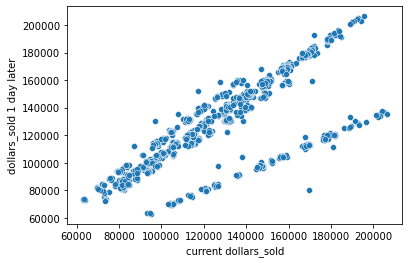

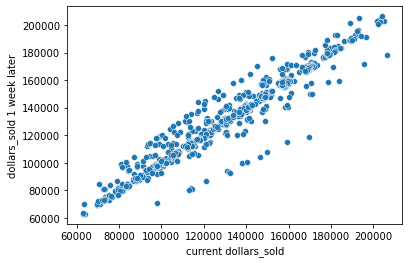

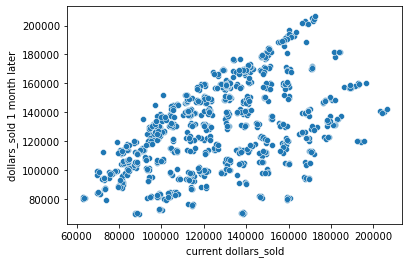

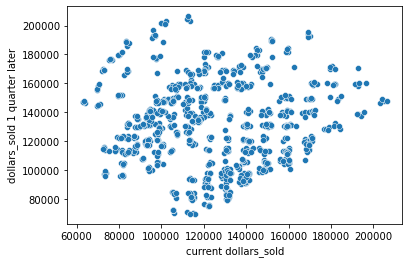

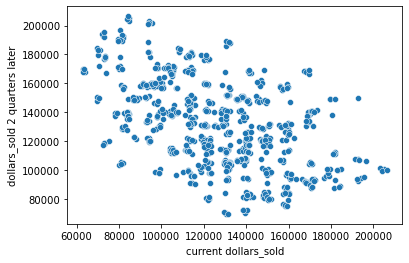

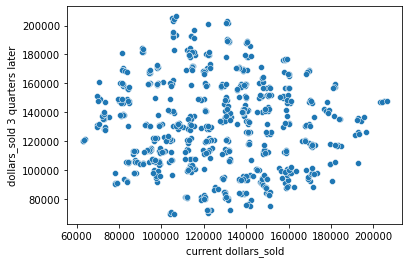

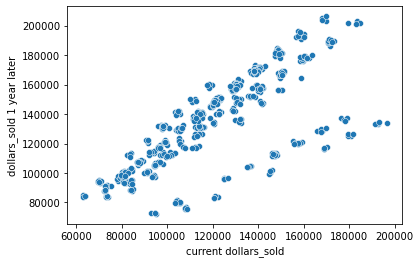

In [17]:
lag_times = [1, 7, 30, 30*3, 30*6, 30*9, 365]
lag_labels = ['1 day', '1 week', '1 month', '1 quarter', '2 quarters', '3 quarters', '1 year']

for lag_time, lag_label in zip(lag_times, lag_labels):
    sns.scatterplot(data=train, x=target, y=train[target].shift(-lag_time))
    plt.xlabel(f'current dollars_sold')
    plt.ylabel(f'dollars_sold {lag_label} later')
    plt.show()

#### autocorrelation

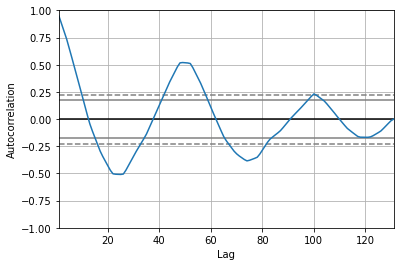

In [18]:
pd.plotting.autocorrelation_plot(train[target].resample('W').mean())
plt.show()

#### seasonal decomposition

In [19]:
y = train[target].resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({'y': result.observed,
                             'trend': result.trend,
                             'seasonal': result.seasonal,
                             'resid': result.resid,})

decomposition['trend_centered'] = decomposition.trend - decomposition.trend.mean()

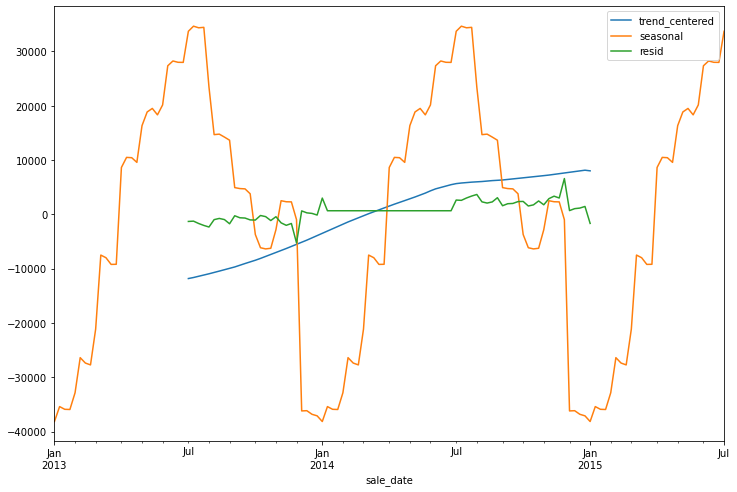

In [20]:
decomposition[['trend_centered', 'seasonal', 'resid']].plot(figsize=(12,8))
plt.show()

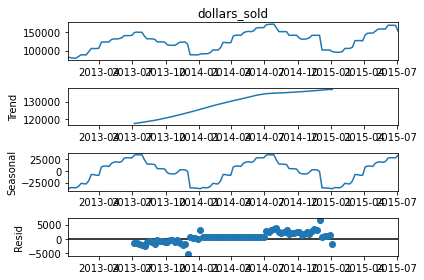

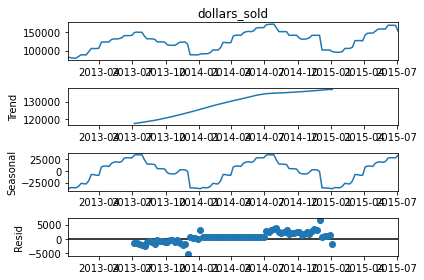

In [21]:
result.plot()

In [22]:
train['bin'] = pd.qcut(train[target], 3, labels=('low', 'mid', 'high'))

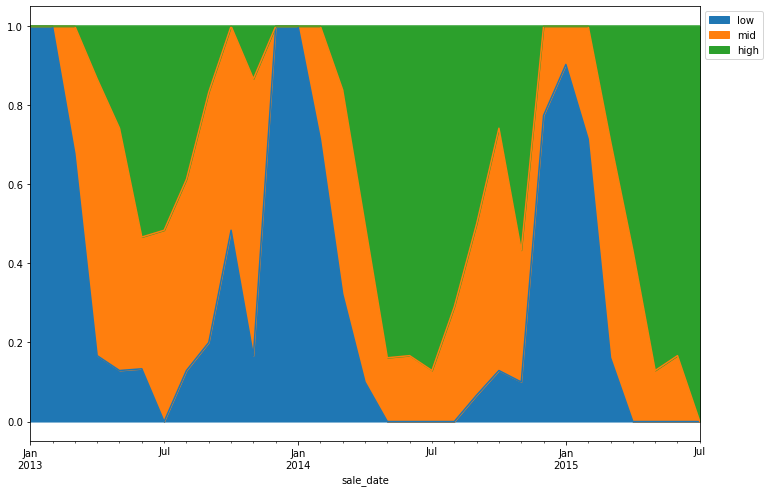

In [23]:
ax = (train.groupby('bin')
           .resample('M')
           .size()
           .unstack(0)
           .apply(lambda row: row / row.sum(), axis=1)
           .plot.area(figsize=(12,8)))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
None

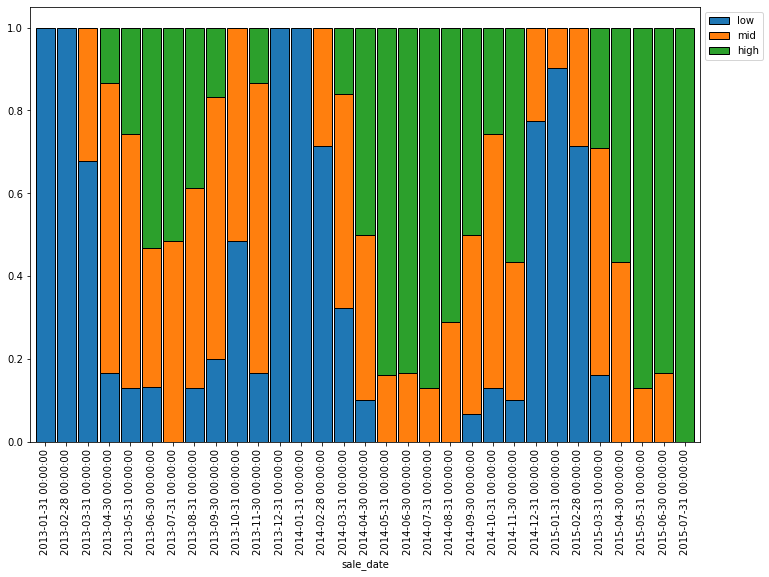

In [24]:
ax = (train.groupby('bin')
           .resample('M')
           .size()
           .unstack(0)
           .apply(lambda row: row / row.sum(), axis=1)
           .plot.bar(stacked=True, width=.9, ec='black', figsize=(12,8)))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
None

# OPSD Germany data

In [ ]:
df = acquire.opsd_germany_data